In [2]:
%load_ext autoreload
%autoreload 2
from astropy import units as u
from astropy import constants as const
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import quad, trapezoid

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

import iqbal_agn_heating_functions as iq
from cluster_measurements import ClusterMeasurements
from iq_agn_heating_2 import NFWProfile

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
z = 0
Ms = np.logspace(13, 17) * u.Msun

In [23]:
nfws = [NFWProfile(z, Mvir=M)for M in Ms]

In [28]:
nfw = nfws[15]
Deltac = nfw.overdensity_const
Deltac

101.14287921960845

In [29]:
nfw.Mvir, nfw.Rvir

(<Quantity 1.67683294e+14 solMass>, <Quantity 1.42774231 Mpc>)

In [30]:
nfw.get_R_from_overdensity(Deltac)

<Quantity 1.42774231 Mpc>

In [31]:
nfw.get_R_from_overdensity(500.)

<Quantity 0.69078036 Mpc>

In [32]:
nfw.R500

<Quantity 0.69078036 Mpc>

In [33]:
nfw.get_rho_s(Deltac, nfw.cvir)

<Quantity 7.89523429e+14 solMass / Mpc3>

In [34]:
nfw.get_rho_s(500., nfw.get_c500())

<Quantity 2.05903563e+15 solMass / Mpc3>

(2.58, 2.65)

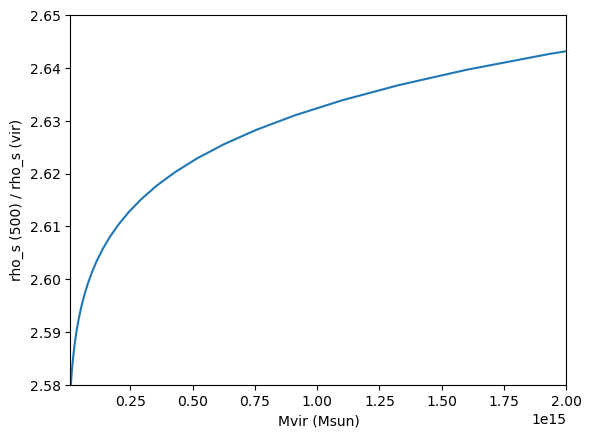

In [35]:
plt.plot(Ms, [nfw.get_rho_s(500., nfw.get_c500())/nfw.get_rho_s(Deltac, nfw.cvir) for nfw in nfws])
plt.xlabel("Mvir (Msun)")
plt.ylabel("rho_s (500) / rho_s (vir)")
plt.xlim(1e13, 2e15)
plt.ylim(2.58, 2.65)

(0.62, 0.66)

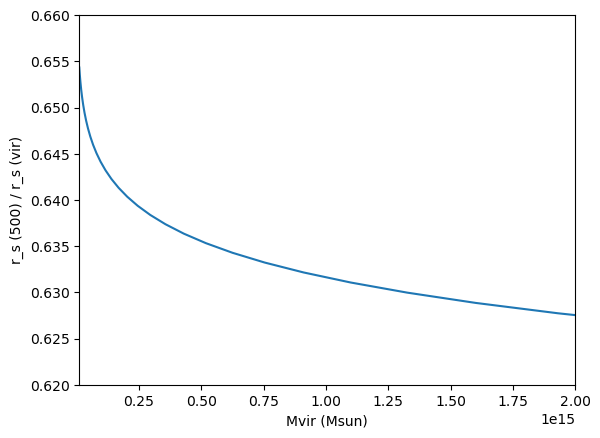

In [36]:
plt.plot(Ms, [(nfw.R500/nfw.get_c500())/(nfw.Rvir/nfw.cvir) for nfw in nfws])
plt.xlabel("Mvir (Msun)")
plt.ylabel("r_s (500) / r_s (vir)")
plt.xlim(1e13, 2e15)
plt.ylim(0.62, 0.66)

In [37]:
nfw.M_enc(nfw.R500), nfw.M500

(<Quantity 9.38847264e+13 solMass>, <Quantity 9.38847264e+13 solMass>)

In [38]:
nfws[-10].Rvir

<Quantity 6.83788729 Mpc>

In [39]:
def Linj(Mvir):
    logLinj = -0.96 + 1.73*np.log10(Mvir/(1e14 * u.Msun))
    return np.power(10, logLinj) * 1e45 * u.erg/u.s

Text(0.5, 1.0, 'Linj vs Mvir for rcutoff = 0.3R500 (eq 26)')

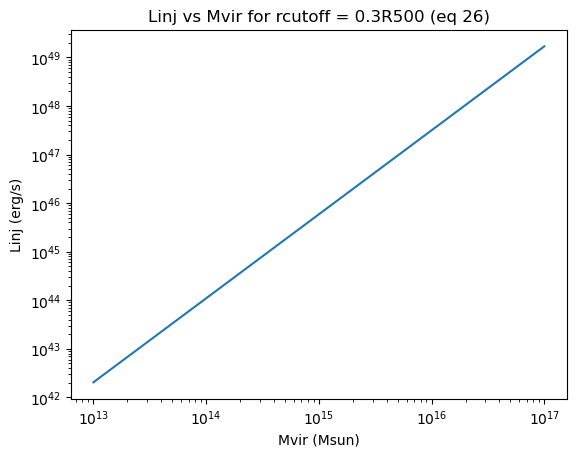

In [40]:
plt.loglog(Ms, Linj(Ms))
plt.xlabel("Mvir (Msun)")
plt.ylabel("Linj (erg/s)")
plt.title("Linj vs Mvir for rcutoff = 0.3R500 (eq 26)")

In [56]:
heating_rates = [nfw.vol_heating_rate([nfw.R500], 
                                      0.3*nfw.R500) for nfw in nfws]

In [57]:
cooling_rates = [nfw.vol_cooling_rate([nfw.R500.value]*u.Mpc) for nfw in nfws]

In [58]:
nfws[0].vol_cooling_rate([nfws[0].R500.value]*u.Mpc)

<Quantity [2.87619592e-31] erg / (cm3 s)>

In [59]:
heating_rates_01 = [nfw.vol_heating_rate([0.1*nfw.R500], 
                                      Linj(nfw.Mvir),
                                      0.3*nfw.R500) for nfw in nfws]
cooling_rates_01 = [nfw.vol_cooling_rate([0.1*nfw.R500.value]*u.Mpc) for nfw in nfws]

UnitTypeError: Can only apply 'exp' function to dimensionless quantities

In [44]:
plt.loglog(Ms, cooling_rates, label="cooling rate at R500")
plt.loglog(Ms, heating_rates, label="heating rate (rc=0.3R500) at R500")
plt.loglog(Ms, cooling_rates_01, label="cooling rate at 0.1R500")
plt.loglog(Ms, heating_rates_01, label="heating rate (rc=0.3R500) at 0.1R500")
plt.xlabel("Mvir (Msun)")
plt.ylabel("heating/cooling rates per volume (erg/s*cm3)")
plt.legend(loc="upper left")

NameError: name 'cooling_rates' is not defined

In [9]:
total_heating_rates = [nfw.total_heating_rate(0.015*nfw.R500, nfw.R500, 
                                      Linj(nfw.Mvir),
                                      0.3*nfw.R500).value for nfw in nfws]

NameError: name 'nfws' is not defined

In [10]:
total_cooling_rates = [nfw.total_cooling_rate(0.015*nfw.R500, nfw.R500).value for nfw in nfws]

NameError: name 'nfws' is not defined

In [11]:
total_heating_rates[20], total_cooling_rates[20]

NameError: name 'total_heating_rates' is not defined

In [12]:
np.subtract(total_heating_rates, total_cooling_rates)

NameError: name 'total_heating_rates' is not defined

In [13]:
plt.loglog(Ms, total_cooling_rates, label="integrated cooling rate")
plt.loglog(Ms, total_heating_rates, label="integrated heating rate")
plt.xlabel("Mvir (Msun)")
plt.ylabel("heating/cooling rates (erg/s)")
plt.legend()

NameError: name 'total_cooling_rates' is not defined

In [14]:
from cluster_functions import c
def vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, s0, m_chi, n=0, f_chi=1, m_psi=0.1*u.GeV):
    with u.set_enabled_equivalencies(u.mass_energy()):
        uth = np.sqrt(T_b / const.m_p.to(u.GeV) + T_chi / m_chi).to(1)
    rho_chi = rho_tot * f_chi

    denominator = ((m_chi + const.m_p) ** 2).to(u.GeV**2)
    numerator = (
            3
            * (T_b - T_chi).to(u.erg)
            * rho_chi.to(u.GeV/u.cm**3)
            * rho_b.to(u.GeV/u.cm**3)
            * c(n)
            * uth ** (n + 1)
            * (const.c.to(u.cm / u.s))
            * s0
        
        )
    #conversion_factor = 0.197*1e-15 * (u.GeV * u.m)
    #print("dm cooling rate", (numerator / denominator).to(u.erg/u.s))
    return (numerator / denominator).to(u.erg/(u.s*u.cm**3))

In [15]:
def virial_temperature(m_chi, M, R, f_chi=1, m_psi=0.1 * u.GeV,):
    frac = f_chi / m_chi + (1 - f_chi) / m_psi
    M_kg = M.to(u.kg, equivalencies=u.mass_energy())
    return (0.3 * const.G * M_kg / (R * frac) * 1 / const.c**2).to(u.GeV)

In [16]:
# a sample cluster
cls = nfws[20]
rs = np.logspace(-2, 1)*u.Mpc

NameError: name 'nfws' is not defined

In [17]:
plt.loglog(rs, cls.T_g(rs.value).to(u.keV), label="baryon temperature profile")
plt.loglog(rs, virial_temperature(1*u.GeV, cls.M_enc(rs), rs).to(u.keV, equivalencies=u.temperature_energy()), label="DM temperature profile (mx = 1 GeV)")
plt.loglog(rs, virial_temperature(1e-1*u.GeV, cls.M_enc(rs), rs).to(u.keV, equivalencies=u.temperature_energy()), label="DM temperature profile (mx = 0.1 GeV)")
plt.loglog(rs, virial_temperature(1e-2*u.GeV, cls.M_enc(rs), rs).to(u.keV, equivalencies=u.temperature_energy()), label="DM temperature profile (mx = 0.01 GeV)")

plt.legend()
plt.xlabel("r (Mpc)")
plt.ylabel("T (keV)")

NameError: name 'rs' is not defined

In [18]:

cls = nfws[20]
virial_temperature(mx, cls.Mvir, cls.Rvir), virial_temperature(mx, cls.M500, cls.R500)


NameError: name 'nfws' is not defined

In [19]:
M01 = cls.M_enc(0.1*cls.R500)
virial_temperature(mx, M01, 0.1*cls.R500)

NameError: name 'cls' is not defined

In [20]:
M10 = cls.M_enc(10*cls.R500)
virial_temperature(mx, M10, 10*cls.R500)

NameError: name 'cls' is not defined

In [21]:
m_chi = 1e-2*u.GeV
T_b = cls.T_g(rs.value).to(u.keV)
T_chi = virial_temperature(m_chi, cls.M_enc(rs), rs).to(u.keV, equivalencies=u.temperature_energy())
rho_tot = cls.rho_tot(rs)
rho_b = cls.rho_g(rs)
sigma0 = 1e-30*u.cm**2

NameError: name 'cls' is not defined

In [22]:
vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, sigma0, m_chi)

NameError: name 'T_b' is not defined

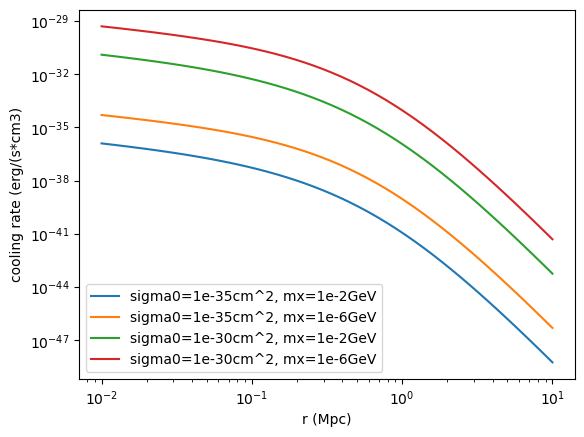

In [173]:
plt.loglog(rs, vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, 1e-35*u.cm**2, m_chi), label="sigma0=1e-35cm^2, mx=1e-2GeV")
plt.loglog(rs, vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, 1e-35*u.cm**2, 1e-6*u.GeV), label="sigma0=1e-35cm^2, mx=1e-6GeV")
plt.loglog(rs, vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, sigma0, m_chi), label="sigma0=1e-30cm^2, mx=1e-2GeV")
plt.loglog(rs, vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, sigma0, 1e-6*u.GeV), label="sigma0=1e-30cm^2, mx=1e-6GeV")
#plt.loglog(rs, vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, 1e-25*u.cm**2, m_chi), label="sigma0=1e-25cm^2, mx=1e-2GeV")
plt.xlabel("r (Mpc)")
plt.ylabel("cooling rate (erg/(s*cm3)")
plt.legend()

In [193]:
def integrated_dm_cooling_rate(rmin, rmax, nfw, s0, m_chi, num = 50, n=0, f_chi=1, m_psi=0.1*u.GeV):
    log_rmin = np.log10(rmin.value)
    log_rmax = np.log10(rmax.value)
    rs = np.logspace(log_rmin, log_rmax, num=num)*u.Mpc

    rho_tot = nfw.rho_tot(rs)
    rho_b = nfw.rho_g(rs)
    T_b = nfw.T_g(rs.value)
    T_chi = virial_temperature(m_chi, nfw.M_enc(rs), rs).to(u.keV, equivalencies=u.temperature_energy())
    
    integrand = (4 * np.pi * np.multiply(
            vol_dm_cooling_rate(T_b, T_chi, rho_tot, rho_b, s0, m_chi).to(u.erg/(u.s*u.Mpc**3)), 
            np.power(rs, 2))).to(u.erg/(u.s*u.Mpc))
    return trapezoid(integrand, rs)

In [194]:
integrated_dm_cooling_rate(0.015*cls.R500, cls.R500, cls, sigma0, m_chi)

<Quantity 6.21516273e+39 erg / s>

In [196]:
total_dm_cooling_rates = [integrated_dm_cooling_rate(0.015*nfw.R500,
                                                         nfw.R500,
                                                         nfw,
                                                         sigma0,
                                                         m_chi).value for nfw in nfws]

In [218]:
n=12
nfws[n].Mvir, (nfws[n].total_heating_rate(0.015*nfws[n].R500, nfws[n].R500, 
                                      Linj(nfws[n].Mvir),
                                      0.3*nfws[n].R500) - nfws[n].total_cooling_rate(0.015*nfws[n].R500, nfws[n].R500))

(<Quantity 9.54095476e+13 solMass>, <Quantity -1.06206275e+43 erg / s>)

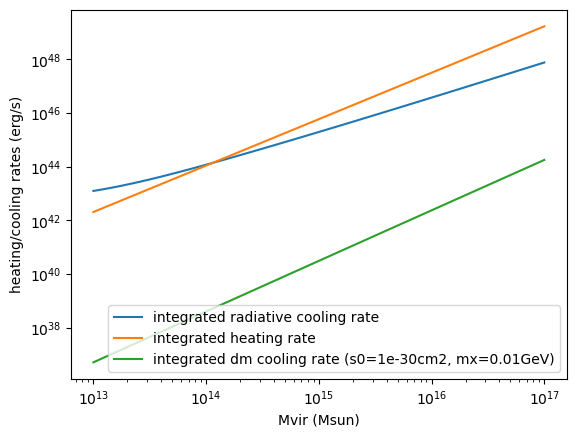

In [208]:
plt.loglog(Ms, total_cooling_rates, label="integrated radiative cooling rate")
plt.loglog(Ms, total_heating_rates, label="integrated heating rate")
plt.loglog(Ms, total_dm_cooling_rates, label="integrated dm cooling rate (s0=1e-30cm2, mx=0.01GeV)")
plt.xlabel("Mvir (Msun)")
plt.ylabel("heating/cooling rates (erg/s)")
plt.legend()
#plt.xlim(1e14, 1e15)
#plt.ylim(1e38, 1e46)

In [198]:
m_chi

<Quantity 0.01 GeV>

In [222]:
cls.P500().to(u.erg/u.cm**3)

<Quantity 5.37420336e-13 erg / cm3>

In [224]:
cls.P500_planelles().to(u.erg/u.cm**3)

<Quantity 4.42674162e-12 erg / cm3>

In [227]:
cls.rs

<Quantity 0.37337824 Mpc>

In [228]:
cls.R500/1.09

<Quantity 0.85959871 Mpc>

(1e-05, 0.01)

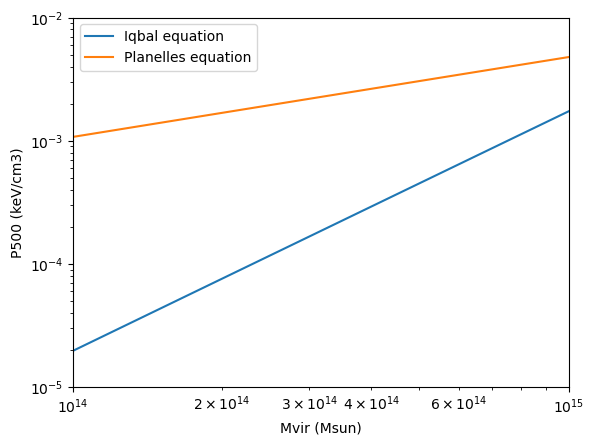

In [69]:
plt.loglog(Ms, [nfw.P500().to(u.keV/u.cm**3).value for nfw in nfws],label='Iqbal equation' )
plt.loglog(Ms, [nfw.P500_planelles().to(u.keV/u.cm**3).value for nfw in nfws], label='Planelles equation')
plt.xlabel('Mvir (Msun)')
plt.ylabel('P500 (keV/cm3)')
plt.legend()
plt.xlim(1e14, 1e15)
plt.ylim(1e-5, 1e-2)